In [59]:
import pandas as pd

df = pd.read_csv("/data/Data/PD/all_df_2.csv")
df = df.rename(columns={"Scanner_type": "Type"})
df = df.rename(columns={"Study": "Site"})


In [61]:
df["Site"].value_counts()

UKBB              245
PD_MCI_CALGARY    121
HAMBURG           113
BIOCOG             94
SALD               78
C-BIG              76
PD_MCI_PLS         62
Japan_dataset      45
Neurocon           42
Taowu              37
Name: Site, dtype: int64

In [62]:
def drop_study(df, sites):
    mask = ~df["Site"].str.contains("|".join(sites), case=True, na=False)
    df = df[mask]
    df.reset_index(drop=True, inplace=True)
    return df

In [63]:
df = drop_study(df, ["PPMI", "HMC", "JGH", "RUH", "SBK", "MUC", "SALD"])

In [93]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap


def visualize(df, bias_vars):
    fig, ax = plt.subplots(1, 2, gridspec_kw={"width_ratios": [6, 1]}, figsize=(7, 3))

    for k in range(2):
        count_df = df.groupby([bias_vars[k], "Group"]).size().unstack(fill_value=0)

        # Create figure

        # Create stacked bar plot
        colors = sns.color_palette("husl", n_colors=len(count_df.columns))
        bottom = np.zeros(len(count_df.index))

        for i, (colname, color) in enumerate(zip(count_df.columns, colors)):
            values = count_df[colname]
            ax[k].bar(count_df.index, values, bottom=bottom, label=colname, color=color)
            # Add count labels in the middle of each segment
            for j, v in enumerate(values):
                if v > 0:  # Only add label if there's a value
                    ax[k].text(
                        j,
                        bottom[j] + v / 2,
                        str(int(v)),
                        ha="center",
                        va="center",
                        fontweight="bold",
                        color="white",
                    )
            bottom += values

        # Customize the plot
        ax[k].set_title(f"Count by {bias_vars[k]}", pad=5)
        ax[k].set_xlabel(f"{bias_vars[k]}")
        ax[0].set_ylabel("Count")
        ax[0].set_xticks(np.arange(9))

        # wrapped_labels = [
        #     "\n".join(wrap(label.get_text(), width=7))
        #     for label in ax[k].get_xticklabels()
        # ]
        # ax[k].set_xticks(np.arange(len(wrapped_labels)))
        # ax[k].set_xticklabels(wrapped_labels)

        # Add legend
        ax[0].legend(title="PD Status", ncols=2, loc="upper right")

        # Add total counts on top of each stack
        # for i, total in enumerate(bottom):
        #     ax[k].text(
        #         i, total, f"{int(total)}", ha="center", va="bottom", fontweight="bold"
        #     )

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()

    return fig

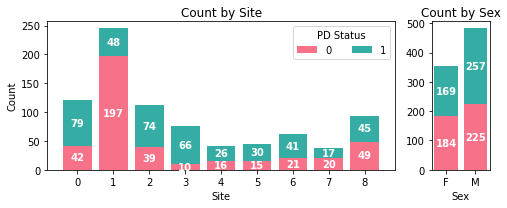

In [94]:
visualize(df, ["Site", "Sex"]).savefig(
    f"/data/Papers/MICCAI-biases/data/sex_study_dist.pdf"
)

In [67]:
def categorize(df, col):
    type_unique = df[col].unique()
    type_categories = {k: v for k, v in zip(type_unique, np.arange(len(type_unique)))}
    print(type_categories)
    df[col] = df[col].map(type_categories)
    return df, type_categories


def binarize(df, col, val):
    df[col] = (df[col] == val).astype("int")
    return df

In [69]:
df, scanner_dict = categorize(df, "Type")
df, study_dict = categorize(df, "Site")
# df = binarize(df, 'Sex', 'M')
df = binarize(df, "Group", "PD")

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7}
{'PD_MCI_CALGARY': 0, 'UKBB': 1, 'HAMBURG': 2, 'C-BIG': 3, 'Neurocon': 4, 'Japan_dataset': 5, 'PD_MCI_PLS': 6, 'Taowu': 7, 'BIOCOG': 8}


In [97]:
df["Group"].value_counts()

1    426
0    409
Name: Group, dtype: int64

In [23]:
grouped_df = df.groupby('Group')['Group'].value_counts()
percentages = (grouped_df / grouped_df.sum()).to_list()
percentages

[0.48982035928143713, 0.5101796407185629]

In [24]:
grouped_df = df.groupby('Sex')['Sex'].value_counts()
percentages = (grouped_df / grouped_df.sum()).to_list()
percentages

[0.4227544910179641, 0.577245508982036]

In [25]:
grouped_df = df.groupby('Study')['Study'].value_counts()
percentages = (grouped_df / grouped_df.sum()).to_list()
percentages

[0.14491017964071856,
 0.2934131736526946,
 0.13532934131736526,
 0.09101796407185629,
 0.05029940119760479,
 0.05389221556886228,
 0.07425149700598803,
 0.04431137724550898,
 0.1125748502994012]

In [26]:
from sklearn.model_selection import train_test_split

def stratified_data_split(df, target_column, train_size=0.5, val_size=0.1, test_size=0.4, random_state=42):
    train_val, test = train_test_split(df, test_size=test_size, stratify=df[target_column], random_state=random_state)
    train, val = train_test_split(train_val, test_size=val_size / (train_size + val_size),
                                  stratify=train_val[target_column], random_state=random_state)
    return train, val, test

In [27]:
df['strat_column'] = df['Study'].astype('str') + '_' + df['Sex'].astype('str') + '_' + df['Group'].astype('str')
df

,Subject,participant_id,Study,Extension,Root,Path_old,Site_2,Group,Group_bin,Sex,Type,Unnamed: 11,Sex_bin,Scanner,Vendor,Path,Home,Site_3,Age,strat_column
0,sub-0144,sub-1343,0,.nii.gz,../affine_using_nifty_reg/,../affine_using_nifty_reg/sub-0144.nii.gz,9,1,1,0,0,NaN,0,0,0,/home/raissa/Documents/Parkinson/Milton_repo/d...,/home/raissa/Documents/Parkinson/Milton_repo/d...,5,68.500000,0_0_1
1,1288906,sub-1943,1,.nii.gz,../affine_using_nifty_reg/,../affine_using_nifty_reg/1288906.nii.gz,39,1,1,1,1,NaN,1,13,3,/home/raissa/Documents/Parkinson/Milton_repo/d...,/home/raissa/Documents/Parkinson/Milton_repo/d...,9,72.750000,1_1_1
2,PASIM_N040,PASIM_N040,2,.nii.gz,../affine_using_nifty_reg/,../affine_using_nifty_reg/PASIM_N040.nii.gz,2,0,0,1,1,NaN,1,13,3,/home/raissa/Documents/Parkinson/Milton_repo/d...,/home/raissa/Documents/Parkinson/Milton_repo/d...,2,68.200000,2_1_0
3,sub-258358,sub-1446,3,.nii.gz,../affine_using_nifty_reg/,../affine_using_nifty_reg/sub-258358.nii.gz,1,1,1,1,2,NaN,1,12,3,/home/raissa/Documents/Parkinson/Milton_repo/d...,/home/raissa/Documents/Parkinson/Milton_repo/d...,1,78.000000,3_1_1
4,patient032036,sub-1614,4,.nii.gz,../affine_using_nifty_reg/,../affine_using_nifty_reg/patient032036.nii.gz,7,1,1,0,3,NaN,0,8,3,/home/raissa/Documents/Parkinson/Milton_repo/d...,/home/raissa/Documents/Parkinson/Milton_repo/d...,4,67.000000,4_0_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
830,PASIM_P031,sub-1124,2,.nii.gz,../affine_using_nifty_reg/,../affine_using_nifty_reg/PASIM_P031.nii.gz,2,1,1,0,1,NaN,0,13,3,/home/raissa/Documents/Parkinson/Milton_repo/d...,/home/raissa/Documents/Parkinson/Milton_repo/d...,2,41.000000,2_0_1
831,1051005,sub-1878,1,.nii.gz,../affine_using_nifty_reg/,../affine_using_nifty_reg/1051005.nii.gz,39,0,0,1,1,NaN,1,13,3,/home/raissa/Documents/Parkinson/Milton_repo/d...,/home/raissa/Documents/Parkinson/Milton_repo/d...,9,62.416667,1_1_0
832,ODN08,sub-1657,5,.nii.gz,../affine_using_nifty_reg/,../affine_using_nifty_reg/ODN08.nii.gz,4,1,1,0,4,NaN,0,18,3,/home/raissa/Documents/Parkinson/Milton_repo/d...,/home/raissa/Documents/Parkinson/Milton_repo/d...,3,66.000000,5_0_1
833,PASIM_P203,sub-1167,2,.nii.gz,../affine_using_nifty_reg/,../affine_using_nifty_reg/PASIM_P203.nii.gz,2,1,1,1,1,NaN,1,13,3,/home/raissa/Documents/Parkinson/Milton_repo/d...,/home/raissa/Documents/Parkinson/Milton_repo/d...,2,55.000000,2_1_1


In [28]:
strata_counts = df['strat_column'].value_counts()
strata_to_drop = strata_counts[strata_counts < 3].index
print(strata_to_drop)
df= df[~df['strat_column'].isin(strata_to_drop)]

Index(['3_1_0'], dtype='object')


In [29]:
train, val, test = stratified_data_split(df, 'strat_column')

In [30]:
def split_plot(train, test, val, column):
    """
    Seaborn-based visualization of splits
    """
    # Prepare long-format data
    plot_data = pd.concat([
        train[column].to_frame().assign(Split='Train'),
        test[column].to_frame().assign(Split='Test'),
        val[column].to_frame().assign(Split='Validation')
    ])
    
    # Create plot
    plt.figure(figsize=(12, 6))
    sns.countplot(data=plot_data, x=column, hue='Split')
    plt.title(f'Split Counts by {column}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'/data/Papers/MICCAI-biases/data/data_split_{column}.pdf')
    plt.show()
    
    return 

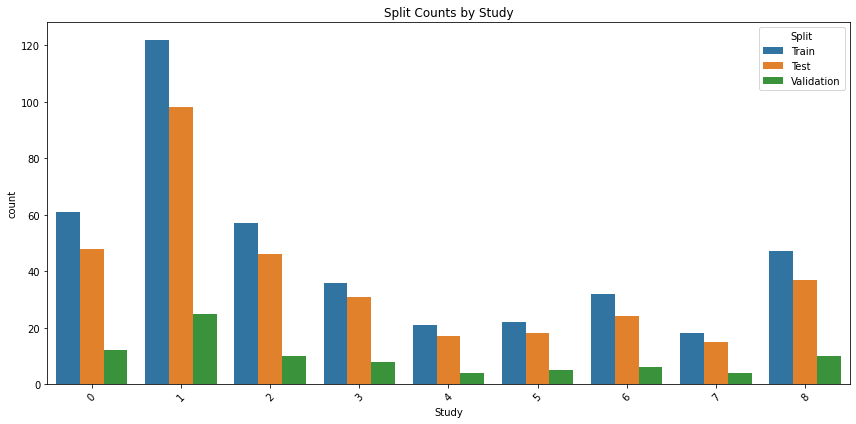

In [31]:
split_plot(train, test, val, 'Study')

In [32]:
train.to_csv('/data/Data/PD/train.csv', index=False)
test.to_csv('/data/Data/PD/test.csv', index=False)
val.to_csv('/data/Data/PD/val.csv', index=False)

In [33]:
import pandas as pd

def generate_summary_df(df, name):
  """Generates a DataFrame summarizing the counts of 'Sex' and 'Group' within each 'Study' in a DataFrame.

  Args:
    df: The DataFrame to summarize.
    name: The name of the DataFrame (e.g., 'train', 'test', 'validation').

  Returns:
    A DataFrame with columns 'Study', 'Sex', 'Count', and 'Group', 'Count'.
  """

  summary_list = []
  for study, group in df.groupby('Study'):
    for sex, count in group['Sex'].value_counts().items():
      summary_list.append([study, 'Sex', sex, count])
    for group_val, count in group['Group'].value_counts().items():
      summary_list.append([study, 'Group', group_val, count])

  summary_df = pd.DataFrame(summary_list, columns=['Study', 'Category', 'Value', 'Count'])
  return summary_df

# Generate summary DataFrames for each dataset
train_summary_df = generate_summary_df(train, 'Train')
test_summary_df = generate_summary_df(test, 'Test')
val_summary_df = generate_summary_df(val, 'Validation')

In [34]:

# Add a 'Source' column to each DataFrame
train_summary_df['Source'] = '0_Train'
test_summary_df['Source'] = '2_Test'
val_summary_df['Source'] = '1_Val'

# Concatenate the DataFrames
combined_df = pd.concat([train_summary_df, test_summary_df, val_summary_df], ignore_index=True)
combined_df

,Study,Category,Value,Count,Source
0,0,Sex,1,37,0_Train
1,0,Sex,0,24,0_Train
2,0,Group,1,40,0_Train
3,0,Group,0,21,0_Train
4,1,Sex,1,73,0_Train
...,...,...,...,...,...
103,7,Group,1,2,1_Val
104,8,Sex,1,6,1_Val
105,8,Sex,0,4,1_Val
106,8,Group,1,5,1_Val


In [35]:
df_pivot = pd.pivot_table(combined_df, index=['Category', 'Value'], columns=['Study', 'Source'], values='Count', fill_value=0)
df_pivot.to_csv('/data/Papers/MICCAI-biases/data/data_split.csv')
df_pivot

Study                0                    1                    2               \
Source         0_Train 1_Val 2_Test 0_Train 1_Val 2_Test 0_Train 1_Val 2_Test   
Category Value                                                                  
Group    0          21     4     17      98    20     79      20     3     16   
         1          40     8     31      24     5     19      37     7     30   
Sex      0          24     5     19      49    10     39      19     3     15   
         1          37     7     29      73    15     59      38     7     31   

Study                3  ...      5       6                    7               \
Source         0_Train  ... 2_Test 0_Train 1_Val 2_Test 0_Train 1_Val 2_Test   
Category Value          ...                                                    
Group    0           4  ...      6      11     2      8      10     2      8   
         1          32  ...     12      21     4     16       8     2      7   
Sex      0          19  ...     10      14     2     10       8     2      7   
         1          17  ...      8      18     4     14      10     2      8   

Study                8               
Source         0_Train 1_Val 2_Test  
Category Value                       
Group    0          25     5     19  
         1          22     5     18  
Sex      0          21     4     16  
         1          26     6     21  

[4 rows x 27 columns]